## Validate CA3 projections in CA1 microcircuit

We implement a model of Schaffer collaterals that connects CA3 PCs with CA1 neurons.

In particular, we considered:

- number of synapses per connection of about 1
- an average distribution across layers as desribed by Bezaire and Soltesz (2013)
- a uniform distribution in XZ plane

In this notebook, you will verify that the above properties are as expected.

---

Import some python packages

In [1]:
import json
from pathlib import Path
from collections import Counter

import numpy as np
import nrrd 
import matplotlib.pyplot as plt
# package to work with the circuit
from bluepysnap import Circuit

Reading and preparing the data

In [2]:
# we fix the random pseudo-generator seed used for the samplings
np.random.seed(42)

In [3]:
circuit_path = '/home/data-bbp/20191017/circuit_config.json'
circuit = Circuit(circuit_path)

In [4]:
print(list(circuit.nodes))
print(list(circuit.edges))

['hippocampus_projections', 'hippocampus_neurons']
['hippocampus_neurons__hippocampus_neurons__chemical', 'hippocampus_projections__hippocampus_neurons__chemical']


In [5]:
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]
proj_cells =circuit.nodes["hippocampus_projections"]
proj_conn =circuit.edges["hippocampus_projections__hippocampus_neurons__chemical"]

### Number of synapse per connection

Also with connections between two brain regions, in this case CA3 and CA1, we can talk about one or more synapses per connection.

---

In the cell below, you will iterate over several pre and postsynaptic cells (respectively CA3 PCs and CA1 neurons), and count how many synapses we have for each connection

In [21]:
# The iteration below could be relatively long.
# To save time, we can sample the number of presynaptic cells (CA3 PCs). If the sample is big enough can be representative of the entire population
npre = 1000
pre = proj_cells.ids(sample=npre)
post = cells.ids()

# data countains the number of neuron pairs having exactly n shared synapses
print("Collecting data on synapses. Can take few minutes.")
data = Counter()

print_at = int(proj_conn.size / 25)
for i, (pre, post, connection_count) in enumerate(proj_conn.iter_connections(pre, post, return_edge_count=True)):
    data[connection_count] += 1
    # print statement to track the progress of the computation
    if i % print_at == 0:
        print(str(i) + '/ ' + str(proj_conn.size) + ' iterations\r', end='')

In [24]:
data

Counter({1: 1860851, 2: 126056, 3: 6230, 4: 249, 5: 8})

Rearrange the result and plot it.

In [7]:
# nsyns is a numpy array equivalent to data with column 0 being the number of connections 
# between a neuron pair and column 1 the number of this type of connection
nsyns = np.array(list(zip(*data.items()))).T
# be sure the number of synapses are correctly ordered 
nsyns = nsyns[nsyns[:,0].argsort()]
print(nsyns)
mean = np.sum(nsyns[:, 0] * nsyns[:, 1])/ np.sum(nsyns[:, 1])
std = np.sqrt(np.sum(nsyns[:, 1] * np.power(nsyns[:, 0] - mean, 2))/np.sum(nsyns[:,  1]))
print("mean number of synapses", mean)
print("number of synapses std", std)

[[       1 29617615]
 [       2  1995541]
 [       3    98384]
 [       4     4007]
 [       5      154]
 [       6        7]
 [       7        1]]
mean number of synapses 1.0695234970153118
number of synapses std 0.26779800817032623


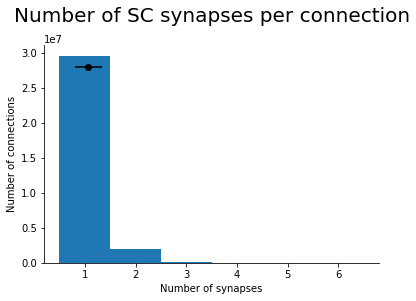

In [22]:
fig, ax = plt.subplots()
ax.hist(nsyns[:, 0], bins=nsyns[:, 0]-0.5, weights=nsyns[:, 1])

_, y1 = ax.get_ylim()
ax.errorbar(mean, y1*0.9, xerr=std, color='k', fmt='o')

ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
ax.set_title('Number of SC synapses per connection', fontsize=20, y=1.08)
ax.set_xlabel('Number of synapses')
ax.set_ylabel('Number of connections')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.show()

### Distribution across layers

Synapses formed by Schaffer collaterals are distributed in a certain way across the different layers of the CA1.

Since this is a distribution in space, you need to work with the atlas, the space where the circuit is defined.

The following cells load the atlas, the voxels, the names and ids of the different subvolumes (columns, layers).

In [9]:
atlas_directory = '/home/data-bbp/20191017/atlas'
br_data, br_metadata = nrrd.read(Path(atlas_directory, "brain_regions.nrrd"))

# hierarchy contains the region hierarchy: 01 -> [mc0->[mc0;SO, mc0;SP, ...], mc1-> [mc1;SO, mc1;SP, ...], ...]
hierarchy = json.load(open(Path(atlas_directory, "hierarchy.json")))

In [10]:
id_layer_map = {}
for column in hierarchy["children"]:
    for region in column["children"]:
        id_ = region["id"]
        layer = region["acronym"].split(";")[-1]
        id_layer_map[id_] = layer
id_layer_map[0] = 'out'

In [11]:
spacing = br_metadata["space directions"].diagonal()
offset = br_metadata["space origin"]

In [12]:
# we sample the edges to reduce the memory usage
N = 500000
sampled_edge_ids = np.random.choice(proj_conn.size, N, replace=False)

In [13]:
# we get the position of all the synapses from the projections and add it to a pandas dataframe
print("Collecting the positions of {} synapses. Can take up to 2 minutes.".format(N))
synapses = proj_conn.positions(sampled_edge_ids, 'afferent', "center")

indices = np.array((synapses[["x", "y", "z"]].to_numpy() - offset) / spacing, dtype=int)
labels = br_data[tuple(indices.T)]
def _apply_mapping(x):
    return id_layer_map[x]

apply_mapping = np.vectorize(_apply_mapping)
layers = apply_mapping(labels)
synapses['layer'] = layers

In [14]:
synapses.head()

,x,y,z,layer
18512239,-213.368530,163.870514,400.422272,SO
9668146,372.459167,453.835205,40.357613,SR
7672760,723.714844,286.502258,780.767822,SR
18115809,359.927521,169.099762,577.217285,SO
17547422,100.581169,475.768188,686.889160,SR


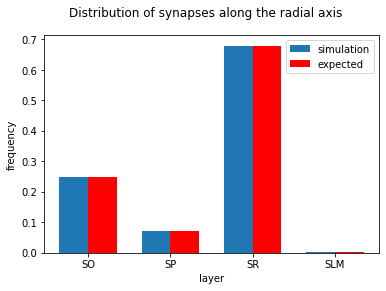

In [18]:
# model distribution
layers = ['SO', 'SP', 'SR', 'SLM']
mod_y_distr = np.array([np.count_nonzero(synapses.layer==layer) for layer in layers], dtype=np.float32)
mod_y_distr = mod_y_distr/mod_y_distr.sum()
exp_y_distr = [0.2476014415, 0.0705293209, 0.6792951748, 0.0025740628] # Bezaire and Soltesz, 2013
x = np.arange(4)
width = 0.35
fig, ax = plt.subplots()
ax.bar(x-width/2, mod_y_distr, width, label='simulation')
ax.bar(x+width/2, exp_y_distr, width, color='r', label='expected')
plt.xticks(x, layers)
fig.suptitle('Distribution of synapses along the radial axis')
ax.set_xlabel('layer')
ax.set_ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

### Distribution over XZ plane

Verify that the synapses are distributed uniformly in the XZ plane

[]

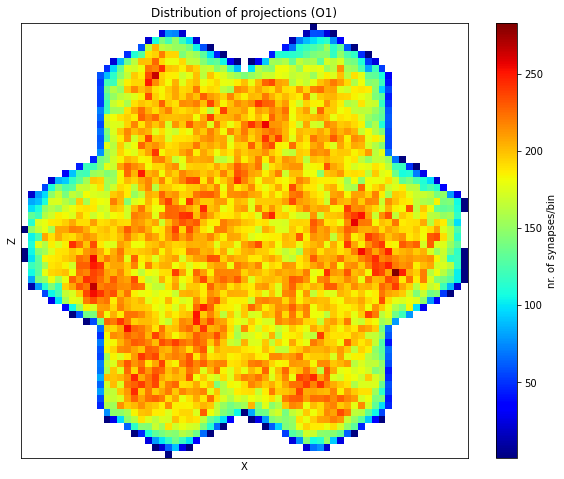

In [16]:
# convert to density matrix
xyz = synapses[["x", "y", "z"]]

import numpy as np
def bin_space(x, y, x_min, x_max, y_min, y_max, bin_size):
    """"Bins the space for 'density plot'"""
    x_bins = np.arange(x_min, x_max, bin_size)
    y_bins = np.arange(y_min, y_max, bin_size)
    x_bins = np.append(x_bins, x_max)
    y_bins = np.append(y_bins, y_max)
    X = np.zeros((len(x_bins)-1, len(y_bins)-1))

    for i, (_x_min, _x_max) in enumerate(zip(x_bins[0:-1], x_bins[1:])):
        idx_x = np.where((_x_min < x) & (x <= _x_max))[0]
        for j, (_y_min, _y_max) in enumerate(zip(y_bins[0:-1], y_bins[1:])):
            idx_y = np.where((_y_min < y[idx_x]) & (y[idx_x] <= _y_max))[0]
            X[i, j] = len(idx_y)
        
    X[np.where(X == 0)] = np.nan
    return X

x_min = -260.0; x_max = 980.0
z_min = -20.0; z_max = 1280.0
bin_size = 20
dens_O1 = bin_space(xyz["x"].values, xyz["z"].values, x_min, x_max, z_min, z_max, bin_size)

# plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
i = ax.imshow(dens_O1, cmap="jet", aspect="auto", interpolation="nearest", origin="lower")
fig.colorbar(i, label="nr. of synapses/bin")
ax.set_title("Distribution of projections (O1)")
ax.set_xlabel("X"); ax.set_ylabel("Z")
ax.set_xticks([]); ax.set_yticks([])